In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [27]:
data = pd.read_csv('../Data/LT_DU_ML_results.csv')
data.head()

nace esize_class gender age_class   lpk education  experience  target  \
0    C        1_49      M     40-49  p721        G2          13    8.20   
1    C        1_49      F     40-49  p334        G2           0    2.51   
2    M      50_249      F     40-49  p522        G2          18    2.19   
3    M      50_249      F     40-49  p522        G2          12    2.19   
4    M      50_249      F     14-29  p522        G2           0    2.19   

        xgb    xgb_mc       grb        rf        lm       svr    voting  \
0  4.503678  4.408886  4.176350  4.778167  4.061958  4.009178  4.390707   
1  3.051344  3.037208  2.980969  3.041897  2.992907  3.122998  3.266770   
2  3.425669  3.228116  3.172908  3.256087  3.945913  2.907824  3.278419   
3  3.298834  3.212965  3.066702  3.219982  3.849712  2.802480  3.200731   
4  2.991804  3.021976  2.920913  2.993366  3.531646  2.741929  3.123216   

         tf  
0  4.049001  
1  3.292751  
2  3.245212  
3  3.176937  
4  2.880577

In [28]:
lpk_names = pd.read_excel('../Data/lpk_en.xlsx')

# Target correlation with model prediction and distribution of residuals

The abbreviations used in this notebook:
 - target — Hourly rate
 - xgb — XGBoost
 - xgb_mc —XGBoost with manual encoding
 - grb — Gradient Boosting 
 - rf — Random Forest
 - lm — Linear Model
 - svr — Support Vector Regression
 - voting — Voting Regressor ensemble of xgb, grb, rf, lm and svr
 - tf — Tensorflow Neural Network 

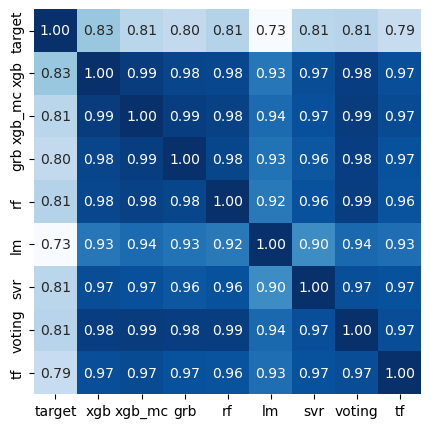

In [29]:
target_models_columns = ['target', 'xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
plt.figure(figsize = (5, 5))
sns.heatmap(data[target_models_columns].corr(), annot=True, fmt=".2f", cmap='Blues', cbar=False);

Extreme Gradient Boosting model with one hot encoding (xgb) has highest correlation with target. Use of ordinal feature encoding does not improve the model. The worst correlation is with  Linear Regression model prediction. The corelation between different models is very strong (≥ 0.90) suggesting that all models are close to potential which can be achieved using chosen features. The regression between target and features is likely to be not linear, because linear regression model has the worst performance and weakest corelation with other models which can represent non linear relationship.

In [30]:
model_columns = ['xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']
residual_columns = [ f'{name}_residual' for name in model_columns]

residuals = data.copy()

for index, model in enumerate(model_columns):
    residuals[residual_columns[index]] = residuals[model] - residuals['target']
    
residuals.columns

Index(['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education',
       'experience', 'target', 'xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr',
       'voting', 'tf', 'xgb_residual', 'xgb_mc_residual', 'grb_residual',
       'rf_residual', 'lm_residual', 'svr_residual', 'voting_residual',
       'tf_residual'],
      dtype='object')

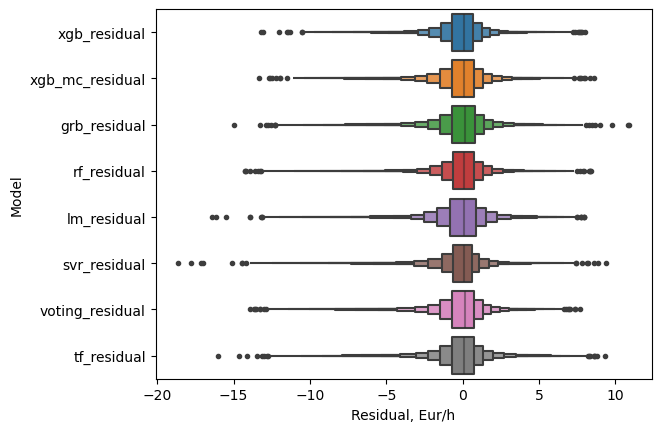

In [31]:
feature_columns = ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education', 'experience']

residuals_long = (
    residuals.
    drop(model_columns, axis=1).
    melt(id_vars=feature_columns, value_vars=residual_columns)
)

sns.boxenplot(data=residuals_long, y='variable',x='value', flier_kws={"marker": "."})
plt.ylabel('Model')
plt.xlabel('Residual, Eur/h');

In [32]:
residuals[residual_columns].quantile([0.1, 0.9]).round(2)

xgb_residual  xgb_mc_residual  grb_residual  rf_residual  lm_residual  \
0.1         -1.66            -1.77         -1.75        -1.63        -1.94   
0.9          1.44             1.51          1.57         1.52         1.78   

     svr_residual  voting_residual  tf_residual  
0.1         -1.64            -1.72        -1.70  
0.9          1.30             1.49         1.55

In [33]:
number_of_negative_predictions = (data[model_columns]<=0).sum()
number_of_negative_predictions

xgb       0
xgb_mc    0
grb       0
rf        0
lm        0
svr       0
voting    0
tf        0
dtype: int64

The residuals of all models are distributed similarly. The negative residuals are larger showing that the target value can be much higher than predicted even though the extreme outliers (>= 90 percentile) are removed in preprocessing. The 80% of residuals for all models except linear regression are between -1.8 and 1.6 Eur/h. All predictions by all models are positive.

In [34]:
fig = px.scatter_matrix(data,
    dimensions=['target', 'xgb', 'rf', 'lm', 'svr', 'tf'],
    width=800,
    height=800,
    opacity=0.05,
    template="plotly_dark"
)
fig.update_traces(diagonal_visible=False,
                  showupperhalf=False,
                  marker=dict(size=2,
                  line=dict(width=0),
                  color='peru'))
fig.show();

The relationship between all models are strong and don't suggest any obvious clustering. The scatterplots with Linear model (lm) are curved in case of all other models indicating that this model was not able to represent the relationship between target value and used features as accurately as others. It also confirms that the relationship between hourly rate and used features is not linear.

# Mean hour rate in occupation groups calculated using models and 2018 survey data

In [35]:
data_long = pd.melt(
                    data,
                    id_vars=['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education', 'experience'],
                    var_name='model'
    )
data_long.head()

nace esize_class gender age_class   lpk education  experience   model  value
0    C        1_49      M     40-49  p721        G2          13  target   8.20
1    C        1_49      F     40-49  p334        G2           0  target   2.51
2    M      50_249      F     40-49  p522        G2          18  target   2.19
3    M      50_249      F     40-49  p522        G2          12  target   2.19
4    M      50_249      F     14-29  p522        G2           0  target   2.19

In [36]:
data_grouped = data_long.groupby(['lpk', 'model']).agg({'value':'mean'}).reset_index()
plot_data = pd.merge(data_grouped, lpk_names, how='left')
observations = data.groupby(['lpk']).size().reset_index()
observations = observations.rename(columns={0:'observations'})
plot_observations = pd.merge(observations, lpk_names, how='left')

In [37]:
subfig = make_subplots(specs=[[{'secondary_y': True}]])

# create two independent figures with px.line each containing data from multiple columns
fig1 = px.line(plot_data,
             x='occupations',
             y='value',
             color='model',
             color_discrete_sequence=px.colors.qualitative.G10)

fig2 = px.bar(plot_observations,
             x='occupations',
             y='observations',
             color_discrete_sequence=px.colors.qualitative.G10,
             opacity=0.5)

fig2.update_traces(yaxis='y2')


subfig.add_traces(fig1.data + fig2.data)

subfig.layout.xaxis.title='Lithuanian Classification of Occupations'
subfig.layout.yaxis.title='Mean hourly rate, Eur/h'
subfig.layout.yaxis2.title='Number of observations'

subfig.update_xaxes(showticklabels=False)
subfig.update_traces(hovertemplate='%{y:.2f}')
subfig.update_layout(hovermode="x unified",
                    template='simple_white',
                    width=800, height=600,
                    margin=dict(l=20, r=20, t=40, b=20),
                    legend=dict(orientation = "h",
                            yanchor="bottom", y=-0.20,
                            xanchor="left",x=0.1)) 
subfig.show()

It seems that the models mostly disagree in cases with smaller number of observations.

In [38]:
lpk_model= data_long.query('model!="target"').groupby(['lpk', 'model']).agg({'value':'mean'}).reset_index()
model_max_min = lpk_model.groupby(['lpk']).agg({'value':['max','min']}).reset_index()
model_amplitude = model_max_min['value', 'max']-model_max_min['value', 'min']

plot_observations['amplitude'] = model_amplitude

fig_observations = px.scatter(plot_observations,
                                x='observations',
                                y='amplitude',
                                color='major_groups',
                                color_discrete_sequence=px.colors.qualitative.G10,
                                hover_name='occupations',
                                template='simple_white',
                                width=800, height=600,
                                labels={
                                    'observations': 'Number of observations',
                                    'amplitude': 'Range of predictions by used models , Eur/h ',
                                    'major_groups': 'Major group'} )

fig_observations.add_vline(x=150,
                            annotation_text="150 observations",
                            line_width=3,
                            line_dash="dash",
                            line_color="grey")

fig_observations.update_layout(legend=dict(
                            yanchor="top", y=0.9,
                            xanchor="right",x=1.0)) 
fig_observations.show()

Largest disagreement between predictions of models were for occupations with small number (>150) of observations. Despite of larger number of observations the disagreement was also high for certain professions in Managers (eg. Directors and CEOs) and Professionals (software developers, analysts, doctors) group. It is likely that the hourly rate for professions, belonging to these groups, are more subjective and can not be well explained by the used features. 